# **CS 4363/5363 Computer Vision**

**Segmentation**

**Author:** [Olac Fuentes](http://www.cs.utep.edu/ofuentes/)<br>
**Last modified:** 10/14/2022<br>

We will be using the functions from skimage segmentation library. See documentation at: https://scikit-image.org/docs/stable/api/skimage.segmentation.html

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import segmentation as seg
from skimage.util import img_as_float
from skimage.filters import gaussian
from google.colab import files
import tensorflow_datasets as tfds
plt.rc('image', cmap='viridis')

# **Downloading images and segmentation masks**

In [ ]:
dataset = tfds.load('oxford_iiit_pet:3.*.*', split='test', download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6OFK3G/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6OFK3G/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
im_sel = np.arange(10)
im_sel = [0,3,4,7,10]
n_imgs = len(im_sel)
image_list, masks = [], []
for i, example in enumerate(dataset):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  if i in im_sel:
    image = example["image"].numpy()
    image = image/np.amax(image)
    mask = np.squeeze(example["segmentation_mask"].numpy())
    image_list.append(image)
    masks.append(mask)
    if len(image_list)>=n_imgs:
      break

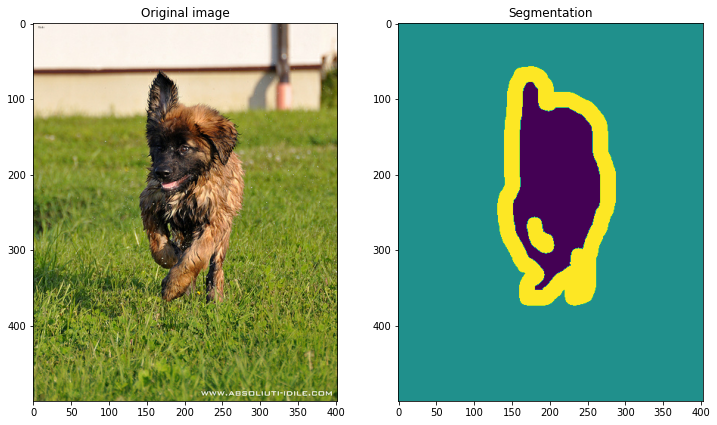

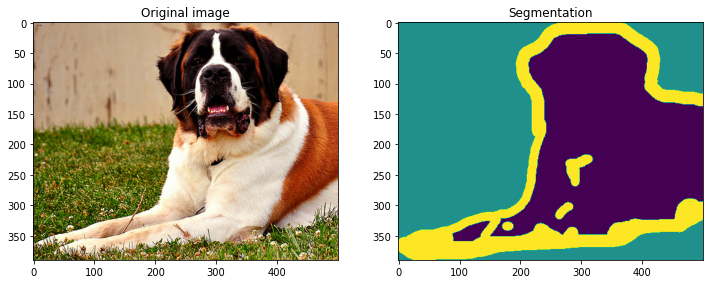

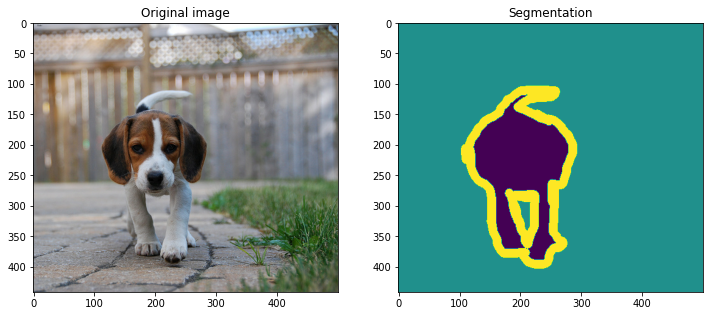

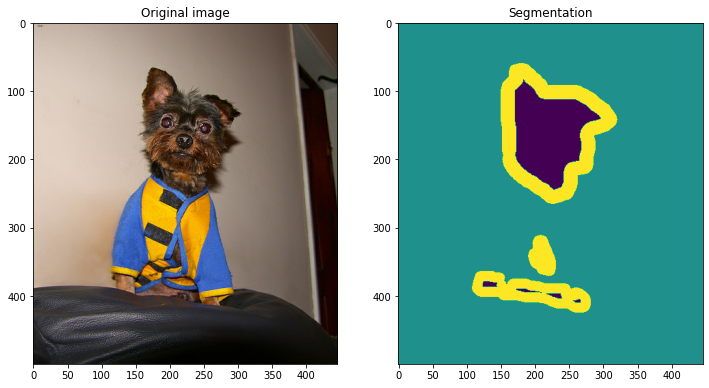

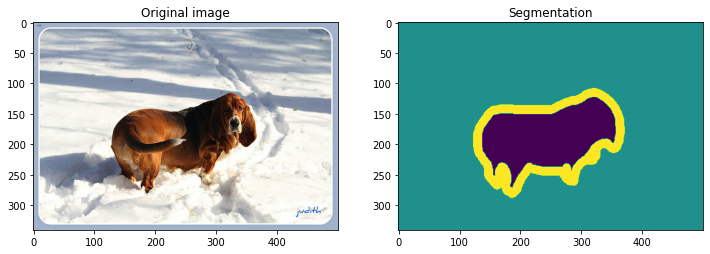

In [ ]:
for i, img in enumerate(image_list):
  fig, ax = plt.subplots(ncols=2, figsize=(12,8))
  ax[0].imshow(img)
  ax[1].imshow(masks[i])
  ax[0].set_title('Original image')
  ax[1].set_title('Segmentation')

Text(0.5, 1.0, 'Segmentation')

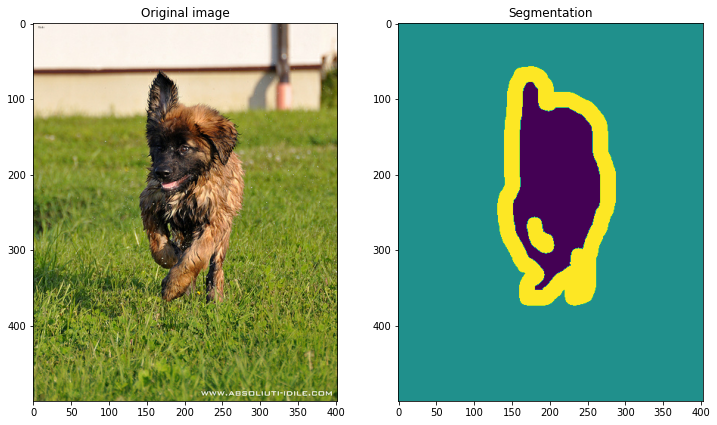

In [ ]:
  fig, ax = plt.subplots(ncols=2, figsize=(12,8))
  ax[0].imshow(image_list[0])
  ax[1].imshow(masks[0])
  ax[0].set_title('Original image')
  ax[1].set_title('Segmentation')

# **Evaluation of Segmentation Algorithms**

Here will see how algorithms perform using the default parameters. In general, performance is not very good, showing that these algorithms are sensitive to parameter selection. 

In [ ]:
def iou(segment,label):
  # Assumes labels contains 3 different values
  # label[i,j] == 1 for foreground object
  # label[i,j] == 2 for background object
  # label[i,j] == 3 for boundary regions, which will be ignored
  background = label==2
  foreground = label==1
  intersection_fg, intersection_bg, union_fg, union_bg  = [], [] ,[], []
  seg_list = list(set(segment.reshape(-1)))
  for s in seg_list:
    S = segment==s
    intersection_fg.append(np.sum(np.logical_and(S,foreground)))
    intersection_bg.append(np.sum(np.logical_and(S,background)))
    union_fg.append(np.sum(np.logical_or(S,foreground)))
    union_bg.append(np.sum(np.logical_or(S,background)))
  iou_fg = np.array(intersection_fg)/np.array(union_fg)
  iou_bg = np.array(intersection_bg)/np.array(union_bg)
  fg_a = np.argmax(iou_fg)
  bg_a = np.argmax(iou_bg)
  return iou_fg[fg_a], iou_bg[bg_a],fg_a,bg_a

In [ ]:
def iou(segment,label):
  # Assumes labels contains 3 different values
  # label[i,j] == 1 for foreground object
  # label[i,j] == 2 for background object
  # label[i,j] == 3 for boundary regions, which will be ignored
  foreground = label==1
  intersection_fg, union_fg  = [], []
  seg_list = list(set(segment.reshape(-1)))
  for s in seg_list:
    S = segment==s
    intersection_fg.append(np.sum(np.logical_and(S,foreground)))
    union_fg.append(np.sum(np.logical_or(S,foreground)))
  iou_fg = np.array(intersection_fg)/np.array(union_fg)
  fg_a = np.argmax(iou_fg)
  return iou_fg[fg_a], fg_a

## **Felzenszwalb Segmentation**

Elapsed time for image 0 is  0.4216 secs
Number of regions found: 7
Foreground iou = 0.5432
Elapsed time for image 1 is  0.3973 secs
Number of regions found: 8
Foreground iou = 0.3950
Elapsed time for image 2 is  0.4668 secs
Number of regions found: 7
Foreground iou = 0.2280
Elapsed time for image 3 is  0.5437 secs
Number of regions found: 9
Foreground iou = 0.5968
Elapsed time for image 4 is  0.3393 secs
Number of regions found: 6
Foreground iou = 0.7709
Mean IOUs:  0.5067850439596383


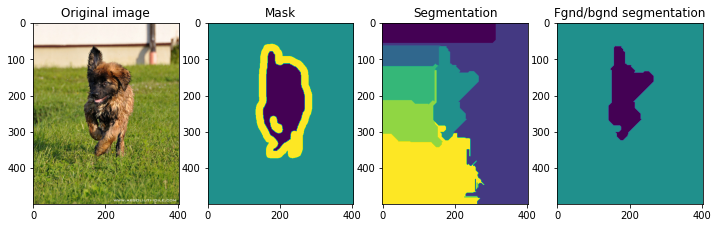

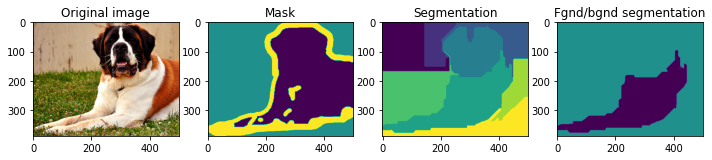

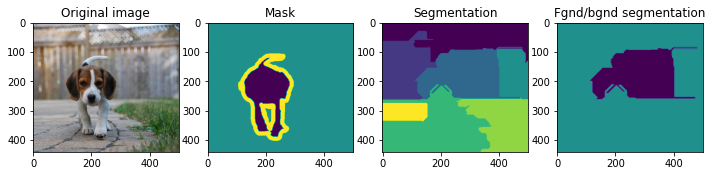

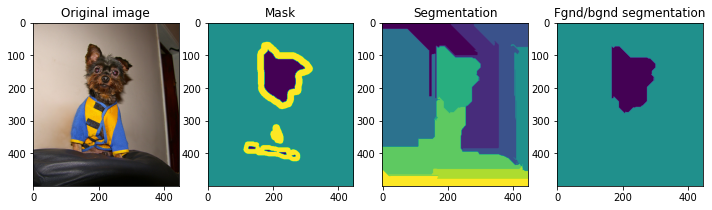

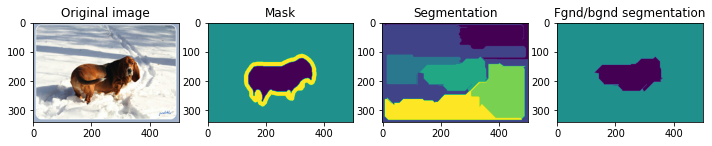

In [ ]:
mean_iou = 0.0
for i, img in enumerate(image_list):
  start = time.time()
  segments = seg.felzenszwalb(img, sigma=8, min_size= 6000)
  elapsed_time = time.time() - start
  print('Elapsed time for image {} is {:7.4f} secs'.format(i, elapsed_time))
  num_regions = len(set(segments.reshape(-1)))
  print('Number of regions found:',num_regions)
  iou_fg, fg_a = iou(segments,masks[i])
  print('Foreground iou = {:6.4f}'.format(iou_fg))
  seg_3 = np.zeros_like(segments)+2
  seg_3[segments==fg_a] = 1
  fig, ax = plt.subplots(ncols=4, figsize=(12,8))
  ax[0].imshow(img)
  ax[1].imshow(masks[i])
  ax[2].imshow(segments)
  ax[3].imshow(seg_3,vmax=3)
  ax[0].set_title('Original image')
  ax[1].set_title('Mask')
  ax[2].set_title('Segmentation')
  ax[3].set_title('Fgnd/bgnd segmentation')
  mean_iou += iou_fg

mean_iou /= len(image_list)  
print('Mean IOUs: ', mean_iou)


## **Quickshift Segmentation**

Elapsed time for image 0 is 41.7308 secs
Number of regions found: 13
Foreground iou = 0.4716
Elapsed time for image 1 is 44.9138 secs
Number of regions found: 10
Foreground iou = 0.3708
Elapsed time for image 2 is 54.1942 secs
Number of regions found: 14
Foreground iou = 0.1589
Elapsed time for image 3 is 45.2874 secs
Number of regions found: 10
Foreground iou = 0.6028
Elapsed time for image 4 is 35.2371 secs
Number of regions found: 10
Foreground iou = 0.4479
Mean IOUs:  0.4103848579067636


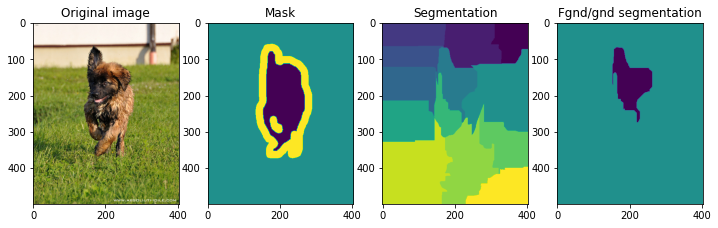

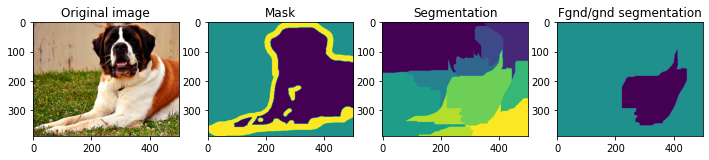

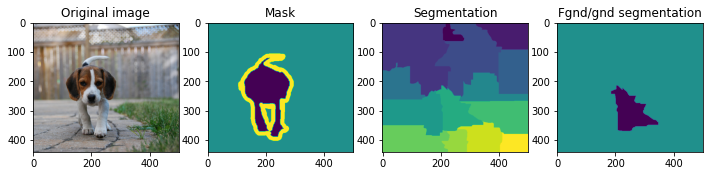

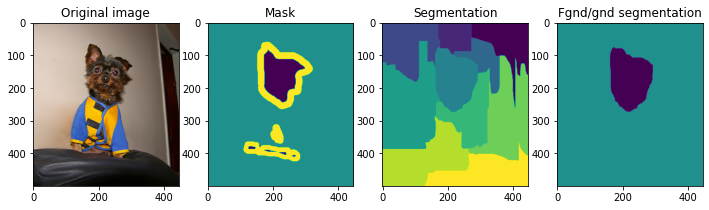

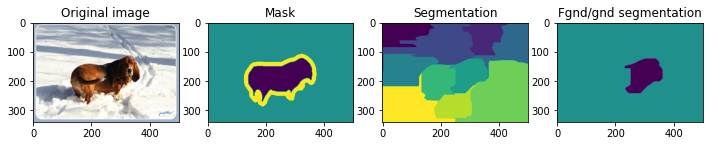

In [20]:
mean_iou = 0.0
for i, img in enumerate(image_list):
  start = time.time()
  # max_dist. Higher means fewer clusters. Which is what we want since there is only the dog and the background
  segments = seg.quickshift(np.float64(img), ratio=1.0, kernel_size=15, max_dist=100, return_tree=False, sigma=10)
  elapsed_time = time.time() - start
  print('Elapsed time for image {} is {:7.4f} secs'.format(i, elapsed_time))
  num_regions = len(set(segments.reshape(-1)))
  print('Number of regions found:',num_regions)
  iou_fg, fg_a = iou(segments,masks[i])
  print('Foreground iou = {:6.4f}'.format(iou_fg))
  seg_3 = np.zeros_like(segments)+2
  seg_3[segments==fg_a] = 1
  fig, ax = plt.subplots(ncols=4, figsize=(12,8))
  ax[0].imshow(img)
  ax[1].imshow(masks[i])
  ax[2].imshow(segments)
  ax[3].imshow(seg_3,vmax=3)
  ax[0].set_title('Original image')
  ax[1].set_title('Mask')
  ax[2].set_title('Segmentation')
  ax[3].set_title('Fgnd/gnd segmentation')
  mean_iou += iou_fg

mean_iou /= len(image_list)  
print('Mean IOUs: ', mean_iou)

## **SLIC Segmentation**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  after removing the cwd from sys.path.


Elapsed time for image 0 is  0.4644 secs
Number of regions found: 12
Foreground iou = 0.5640
Elapsed time for image 1 is  0.6480 secs
Number of regions found: 12
Foreground iou = 0.2190
Elapsed time for image 2 is  0.4957 secs
Number of regions found: 12
Foreground iou = 0.5982
Elapsed time for image 3 is  0.3801 secs
Number of regions found: 12
Foreground iou = 0.4511
Elapsed time for image 4 is  0.2912 secs
Number of regions found: 12
Foreground iou = 0.4054
Mean IOUs:  0.4475582006877746


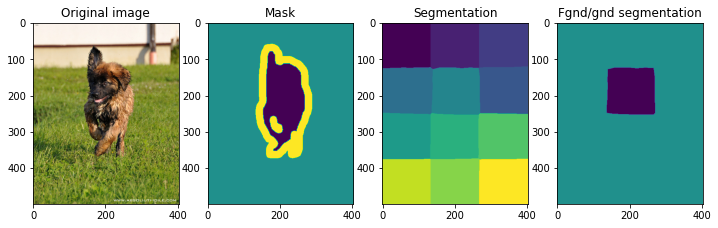

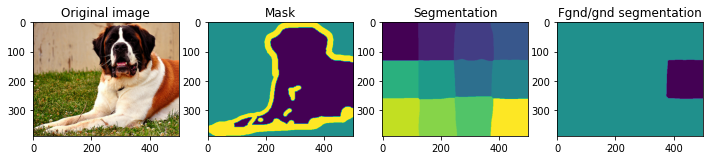

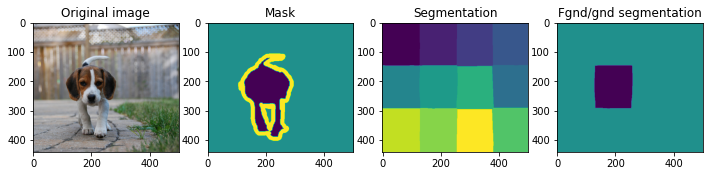

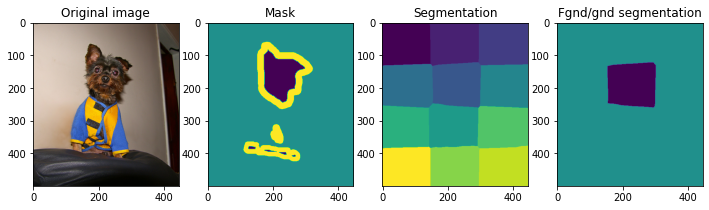

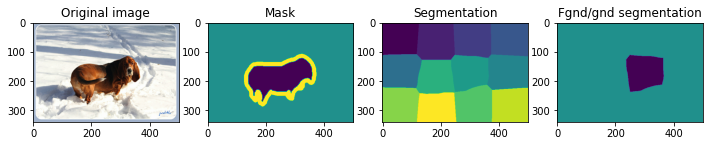

In [39]:
mean_iou = 0.0
for i, img in enumerate(image_list):
  start = time.time()
  segments = seg.slic(img, n_segments=12, compactness=200.0, sigma=8)
  elapsed_time = time.time() - start
  print('Elapsed time for image {} is {:7.4f} secs'.format(i, elapsed_time))
  num_regions = len(set(segments.reshape(-1)))
  print('Number of regions found:',num_regions)
  iou_fg, fg_a = iou(segments,masks[i])
  print('Foreground iou = {:6.4f}'.format(iou_fg))
  seg_3 = np.zeros_like(segments)+2
  seg_3[segments==fg_a] = 1
  fig, ax = plt.subplots(ncols=4, figsize=(12,8))
  ax[0].imshow(img)
  ax[1].imshow(masks[i])
  ax[2].imshow(segments)
  ax[3].imshow(seg_3,vmax=3)
  ax[0].set_title('Original image')
  ax[1].set_title('Mask')
  ax[2].set_title('Segmentation')
  ax[3].set_title('Fgnd/gnd segmentation')

  mean_iou += iou_fg

mean_iou /= len(image_list)  
print('Mean IOUs: ', mean_iou)

## **Watershed Segmentation**

Elapsed time for image 0 is  0.1269 secs
Number of regions found: 24
Foreground iou = 0.4281
Elapsed time for image 1 is  0.1349 secs
Number of regions found: 24
Foreground iou = 0.2741
Elapsed time for image 2 is  0.1298 secs
Number of regions found: 25
Foreground iou = 0.3905
Elapsed time for image 3 is  0.1278 secs
Number of regions found: 25
Foreground iou = 0.3579
Elapsed time for image 4 is  0.2250 secs
Number of regions found: 24
Foreground iou = 0.7711
Mean IOUs:  0.4443420952554405


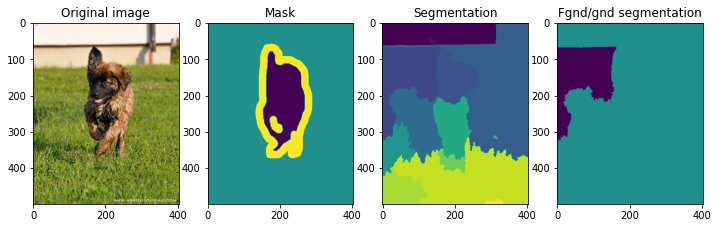

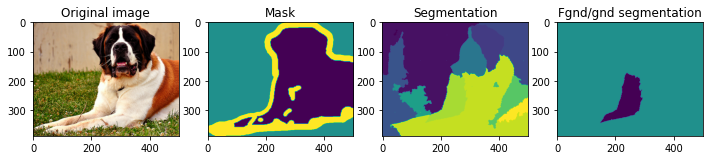

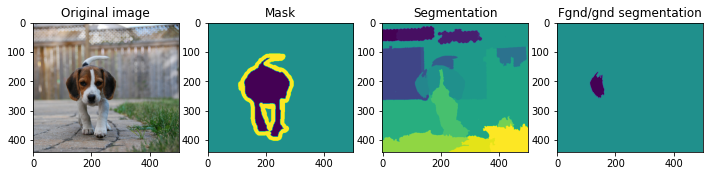

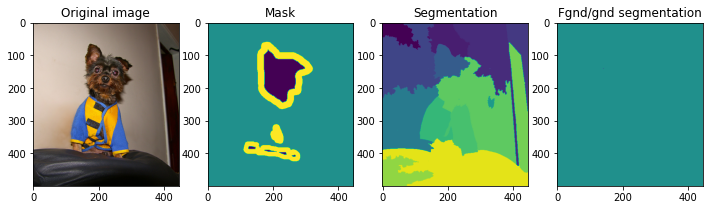

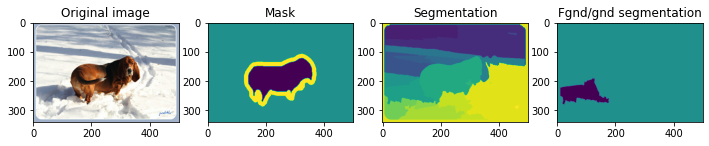

In [42]:
mean_iou = 0.0
for i, img in enumerate(image_list):
  start = time.time()
  gradient = sobel(rgb2gray(img))
  segments = seg.watershed(gradient, markers= 25)
  elapsed_time = time.time() - start
  print('Elapsed time for image {} is {:7.4f} secs'.format(i, elapsed_time))
  num_regions = len(set(segments.reshape(-1)))
  print('Number of regions found:',num_regions)
  iou_fg, fg_a = iou(segments,masks[i])
  print('Foreground iou = {:6.4f}'.format(iou_fg))
  seg_3 = np.zeros_like(segments)+2
  seg_3[segments==fg_a] = 1
  fig, ax = plt.subplots(ncols=4, figsize=(12,8))
  ax[0].imshow(img)
  ax[1].imshow(masks[i])
  ax[2].imshow(segments)
  ax[3].imshow(seg_3,vmax=3)
  ax[0].set_title('Original image')
  ax[1].set_title('Mask')
  ax[2].set_title('Segmentation')
  ax[3].set_title('Fgnd/gnd segmentation')
  mean_iou += iou_fg

mean_iou /= len(image_list)  
print('Mean IOUs: ', mean_iou)